In [90]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import zscore
import pingouin as pg
from scipy.stats import shapiro, kstest, anderson
from statsmodels.stats.diagnostic import het_goldfeldquandt, lilliefors 
import joblib



In [2]:
# Carregamento da base de dados
df_colesterol = pd.read_csv('./datasets/modelo_colesterol.csv')

In [3]:
# Visualização os dados do arquivo
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Grupo Sanguíneo     996 non-null    object 
 2   Fumante             997 non-null    object 
 3   Nível de Atividade  996 non-null    object 
 4   Idade               997 non-null    float64
 5   Peso                997 non-null    float64
 6   Altura              997 non-null    float64
 7   Colesterol          1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


- Preparando os dados para EDA
- Analisando o sqruivo e o mesmo possui dados nulos, será necessario tratar esses dados.
- Converte a coluna idade para int
- Remover a coluna id, pois não influencia na analise e na predição
- Remover os acentos das colunas e renomear as colunas


In [4]:
# Removenado a coluna id
df_colesterol.drop(columns=['Id'], axis=1, inplace=True)

In [5]:
# Renomeando as colunas
df_colesterol.columns = [
    'grupo_sanguineo',
    'fumante',
    'nivel_atividade_fisica',
    'idade',
    'peso',
    'altura',
    'nivel_colesterol'
]

In [6]:
# Copiando o dataframe para realizar a analise dos dados
df_colesterol_eda = df_colesterol.copy()

In [7]:
# Copiando dataframe para criar um bucket
df_colesterol_bucketing = df_colesterol.copy()

In [8]:
# Visualizando os dados
df_colesterol_eda.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79
3,A,Não,Alto,43.0,120.2,167.0,336.24
4,AB,Não,Baixo,79.0,88.5,175.0,226.23
5,B,Não,Baixo,68.0,66.8,170.0,185.31
6,A,Sim,Baixo,60.0,117.3,181.0,289.33
7,O,Sim,Moderado,35.0,86.9,174.0,216.48
8,O,Não,Baixo,62.0,81.3,166.0,235.30
9,B,Sim,Alto,44.0,32.7,165.0,97.79


In [9]:
df_colesterol_eda.grupo_sanguineo.unique()

array(['B', 'A', 'O', 'AB', nan], dtype=object)

In [10]:
# Verificando os valores nulos
df_colesterol_eda.isna().sum()

grupo_sanguineo           4
fumante                   3
nivel_atividade_fisica    4
idade                     3
peso                      3
altura                    3
nivel_colesterol          0
dtype: int64

In [11]:
# Medidas estatisticas do DF
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,997.000000,997.000000,997.000000,1000.000000
mean,49.206620,76.496690,174.889669,199.453260
std,17.476704,21.439132,8.844703,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.700000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,65.000000,90.200000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


In [12]:
# Utilizar a mediana para preencher os valores nulos, quando existir outliers
# Coletar medidas das varivaveis categoricas
moda_grupo_sang = df_colesterol_eda.grupo_sanguineo.mode()
moda_fumante = df_colesterol_eda.fumante.mode()
moda_nivel_atividade_fisica = df_colesterol_eda.nivel_atividade_fisica.mode()

In [13]:
# Coletar medidas das variaveis numericas
mediana_idade = df_colesterol_eda.idade.median()
mediana_peso = df_colesterol_eda.peso.median()
mediana_altura = df_colesterol_eda.altura.median()

In [14]:
# Preencher os valores nulos
df_colesterol_eda.fillna(value={
    'grupo_sanguineo': moda_grupo_sang[0],
    'fumante': moda_fumante[0],
    'nivel_atividade_fisica': moda_nivel_atividade_fisica[0],
    'idade': mediana_idade,
    'peso': mediana_peso, 
    'altura': mediana_altura
},inplace=True)

In [15]:
# Verificando os valores nulos
df_colesterol_eda.isna().sum()

grupo_sanguineo           0
fumante                   0
nivel_atividade_fisica    0
idade                     0
peso                      0
altura                    0
nivel_colesterol          0
dtype: int64

In [16]:
# Convertendo a coluna idade para int e altura para int
df_colesterol_eda.idade = df_colesterol_eda.idade.astype(int)
df_colesterol_eda.altura = df_colesterol_eda.altura.astype(int)

In [17]:
# Visualizando os dados
df_colesterol_eda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         1000 non-null   object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   int64  
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   int64  
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [18]:
# Visualizando os 10 primeiros registros
df_colesterol_eda.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98
2,O,Não,Alto,25,64.8,180,161.79
3,A,Não,Alto,43,120.2,167,336.24
4,AB,Não,Baixo,79,88.5,175,226.23
5,B,Não,Baixo,68,66.8,170,185.31
6,A,Sim,Baixo,60,117.3,181,289.33
7,O,Sim,Moderado,35,86.9,174,216.48
8,O,Não,Baixo,62,81.3,166,235.30
9,B,Sim,Alto,44,32.7,165,97.79


<Axes: xlabel='idade'>

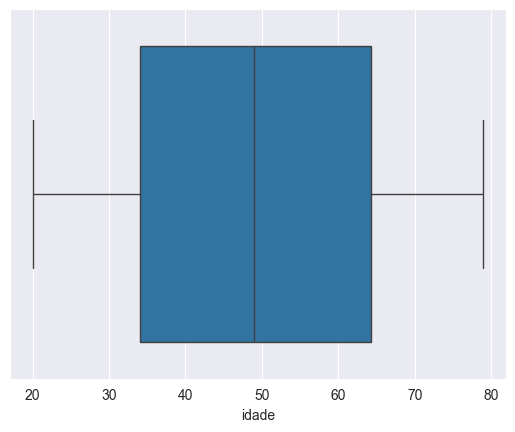

In [19]:
# Verificar/ detectar outliers - Idade
sns.boxplot(data=df_colesterol_eda, x='idade')

<Axes: xlabel='peso'>

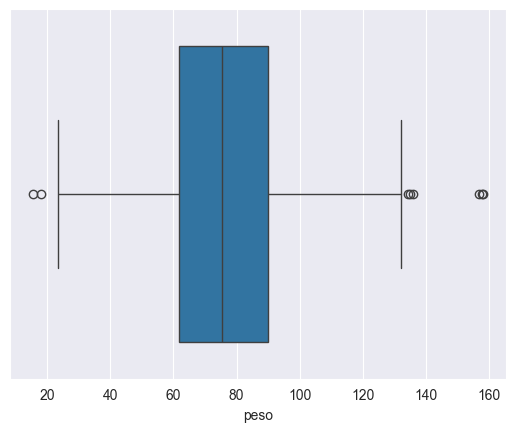

In [20]:
# Verificar/ detectar outliers - Peso
sns.boxplot(data=df_colesterol_eda, x='peso')

In [21]:
# Filtrando o publica a ser removido
df_colesterol_eda[df_colesterol_eda.peso < 40]

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
9,B,Sim,Alto,44,32.7,165,97.79
26,AB,Não,Alto,47,24.8,168,72.62
71,AB,Não,Alto,63,35.2,178,91.63
73,A,Não,Baixo,50,36.5,167,109.60
74,O,Sim,Moderado,43,34.5,161,111.93
79,O,Não,Moderado,45,38.1,161,120.96
87,O,Não,Alto,38,37.5,188,84.80
143,O,Não,Moderado,58,38.0,173,107.50
175,A,Não,Alto,28,37.2,166,108.82
267,A,Não,Moderado,72,36.8,165,112.05


In [22]:
# Removendo os outliers
# Removendo dados incrogrentes do dataset
# remover publico do dataframe
df_colesterol_eda.drop(df_colesterol_eda[df_colesterol_eda['peso'] < 40].index, axis=0, inplace=True)


In [23]:
# Verificando os dados do dataframe
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         963 non-null    object 
 1   fumante                 963 non-null    object 
 2   nivel_atividade_fisica  963 non-null    object 
 3   idade                   963 non-null    int64  
 4   peso                    963 non-null    float64
 5   altura                  963 non-null    int64  
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 60.2+ KB


<Axes: xlabel='altura'>

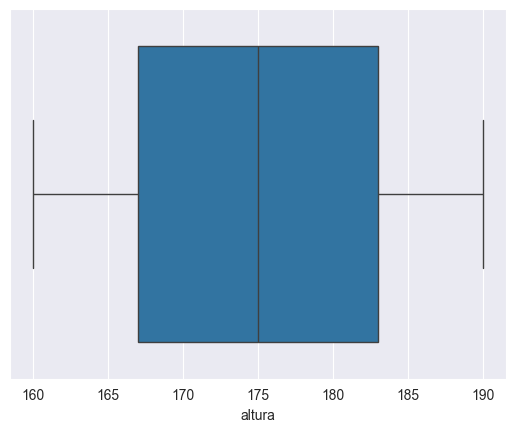

In [24]:
# Verificar/ detectar outliers - Altura
sns.boxplot(data=df_colesterol_eda, x='altura')

<Axes: xlabel='nivel_colesterol'>

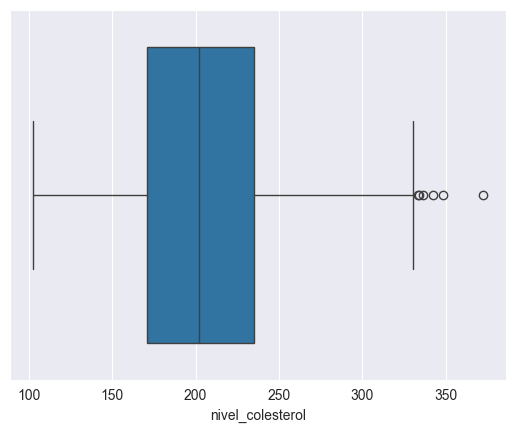

In [25]:
# Verificar variavel nivel_colesterol
sns.boxplot(data=df_colesterol_eda, x='nivel_colesterol')

<Axes: xlabel='grupo_sanguineo', ylabel='nivel_colesterol'>

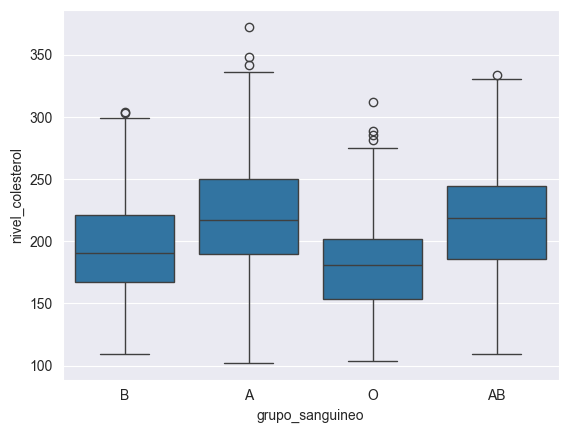

In [26]:
# Cruzando as variaveis categoricas com a variavel nivel_colesterol
sns.boxplot(data=df_colesterol_eda, x='grupo_sanguineo', y='nivel_colesterol')

<Axes: xlabel='fumante', ylabel='nivel_colesterol'>

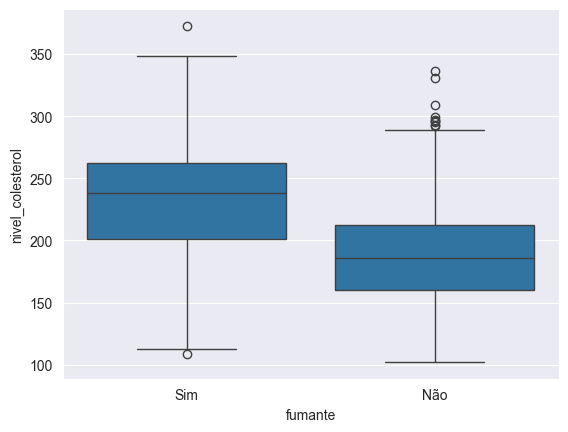

In [27]:
# Cruzamento de variaveis fumanter com nivel_colesterol
sns.boxplot(data=df_colesterol_eda, x='fumante', y='nivel_colesterol')

<Axes: xlabel='nivel_atividade_fisica', ylabel='nivel_colesterol'>

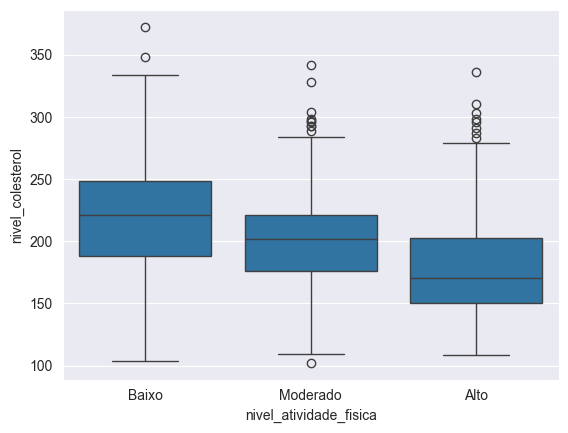

In [28]:
# Cruzamento de variaveis nivel_atividade_fisica com nivel_colesterol
sns.boxplot(data=df_colesterol_eda, x='nivel_atividade_fisica', y='nivel_colesterol')

<Axes: xlabel='idade', ylabel='nivel_colesterol'>

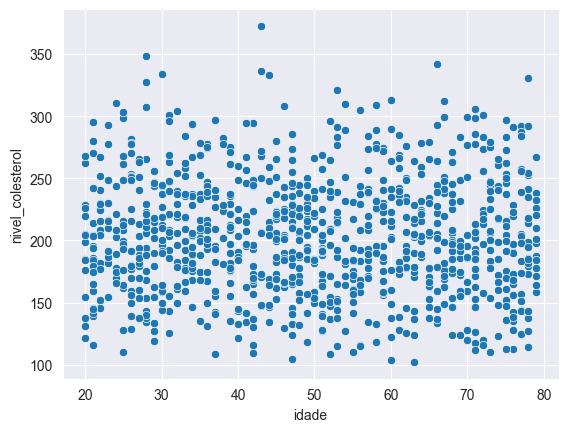

In [29]:
# Diagrama de dispersão - Cruzamento de variaveis categoricas com nivel_colesterol
sns.scatterplot(data=df_colesterol_eda, x='idade', y='nivel_colesterol')


<Axes: xlabel='peso', ylabel='nivel_colesterol'>

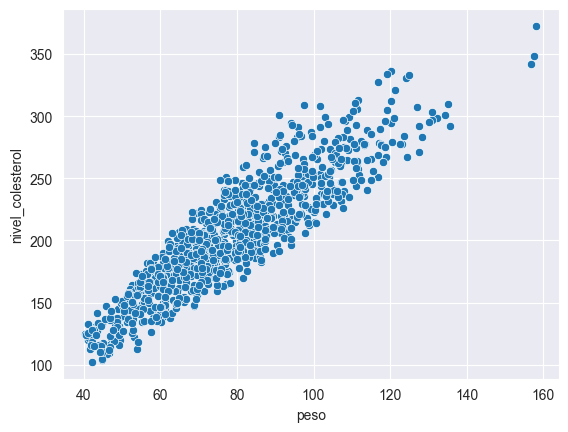

In [30]:
# Diagrama de dispersão - Cruzamento de variaveis categoricas com peso
sns.scatterplot(data=df_colesterol_eda, x='peso', y='nivel_colesterol')

<Axes: xlabel='altura', ylabel='nivel_colesterol'>

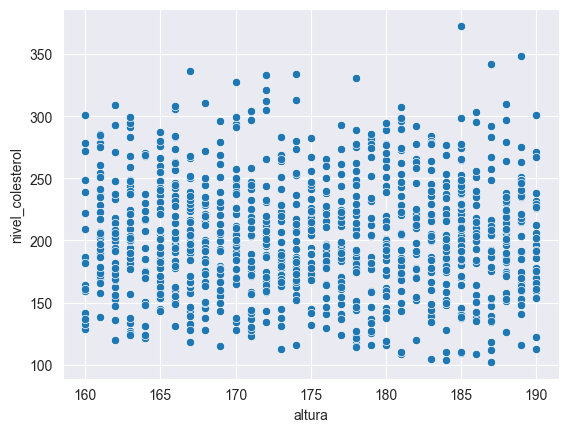

In [31]:
sns.scatterplot(df_colesterol_eda, x='altura', y='nivel_colesterol')

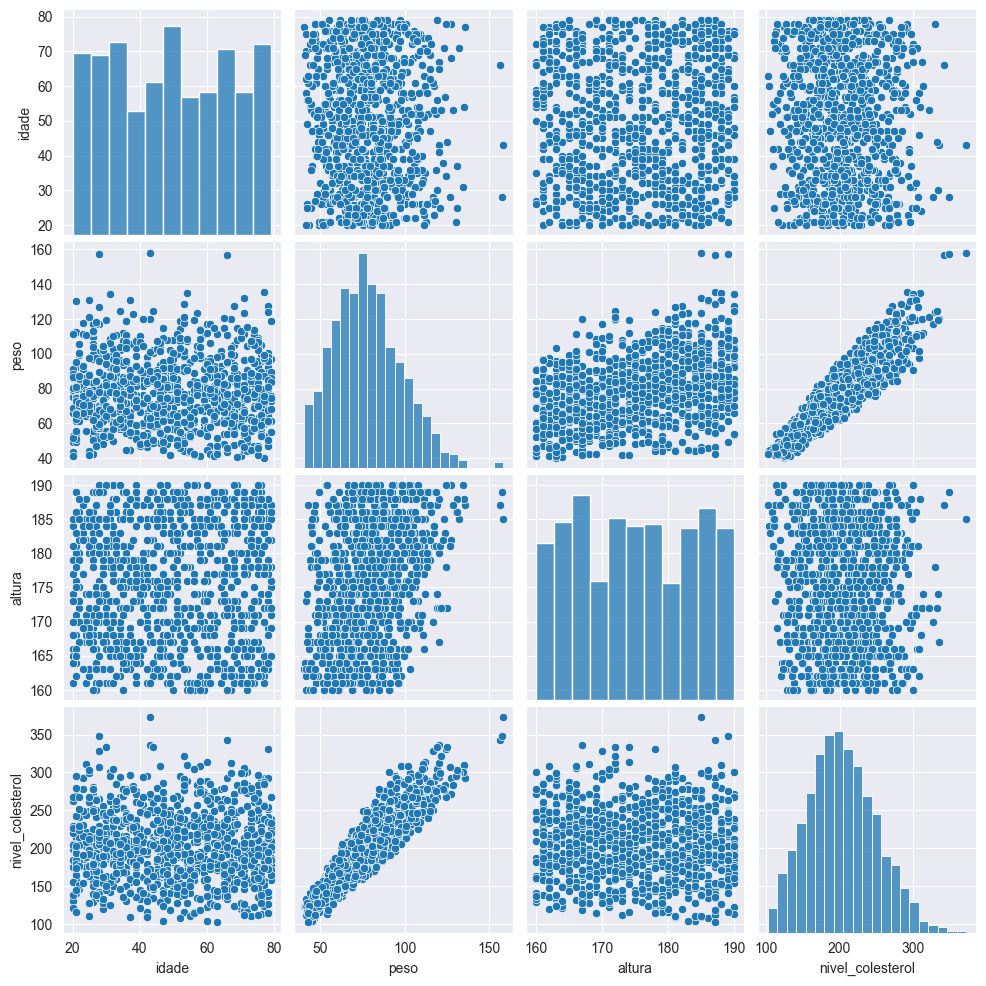

In [32]:
# Variaveis númericas
sns.pairplot(df_colesterol_eda)

In [33]:
# Convertendo a variaveis categoricas para numericas, usando One Hot Encoding do pandas
df_colesterol_eda = pd.get_dummies(df_colesterol_eda, columns=['grupo_sanguineo', 'fumante'], dtype='int64')

In [34]:
df_colesterol_eda.head(10)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,Baixo,33,85.1,186,199.63,0,0,1,0,0,1
1,Moderado,68,105.0,184,236.98,1,0,0,0,1,0
2,Alto,25,64.8,180,161.79,0,0,0,1,1,0
3,Alto,43,120.2,167,336.24,1,0,0,0,1,0
4,Baixo,79,88.5,175,226.23,0,1,0,0,1,0
5,Baixo,68,66.8,170,185.31,0,0,1,0,1,0
6,Baixo,60,117.3,181,289.33,1,0,0,0,0,1
7,Moderado,35,86.9,174,216.48,0,0,0,1,0,1
8,Baixo,62,81.3,166,235.30,0,0,0,1,1,0
10,Baixo,57,123.6,183,283.87,1,0,0,0,0,1


# esse processo é conhecido como one hot encoding, onde transformamos as variaveis categoricas em variaveis numericas

In [35]:
# Converter variavel categorica ordinal em numerica, usando factorize do pandas
df_colesterol_eda['nivel_atividade_fisica'] = pd.factorize(df_colesterol_eda['nivel_atividade_fisica'])[0]

In [36]:
df_colesterol_eda.head(10)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,0,33,85.1,186,199.63,0,0,1,0,0,1
1,1,68,105.0,184,236.98,1,0,0,0,1,0
2,2,25,64.8,180,161.79,0,0,0,1,1,0
3,2,43,120.2,167,336.24,1,0,0,0,1,0
4,0,79,88.5,175,226.23,0,1,0,0,1,0
5,0,68,66.8,170,185.31,0,0,1,0,1,0
6,0,60,117.3,181,289.33,1,0,0,0,0,1
7,1,35,86.9,174,216.48,0,0,0,1,0,1
8,0,62,81.3,166,235.30,0,0,0,1,1,0
10,0,57,123.6,183,283.87,1,0,0,0,0,1


<Axes: >

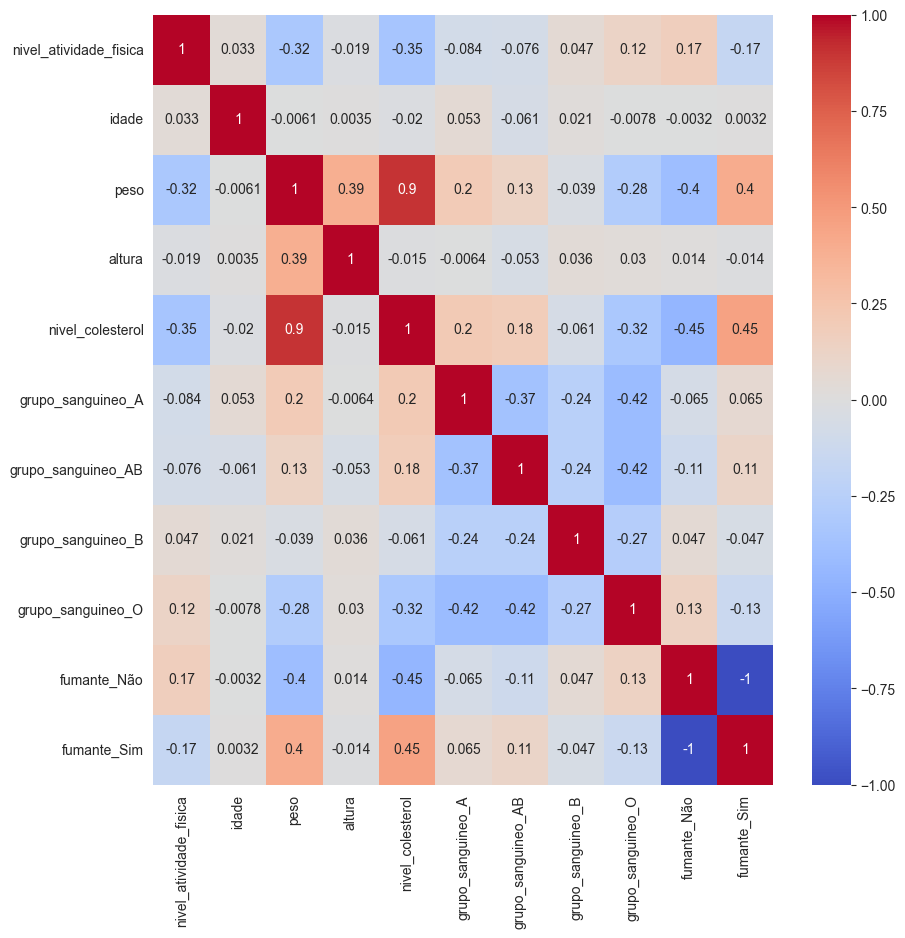

In [37]:
# Mapa de calor, com correlação entre as variaveis
plt.figure(figsize=(10, 10))
sns.heatmap(df_colesterol_eda.corr(), annot=True, cmap='coolwarm')

<Axes: >

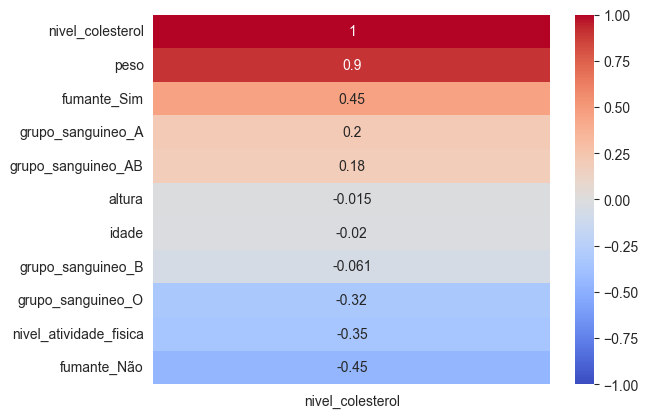

In [38]:
# formato de ranking, somente correlação com a a variavel target
sns.heatmap(df_colesterol_eda.corr()[['nivel_colesterol']].sort_values(by='nivel_colesterol', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

In [39]:
# Bucket idade
bins_idade = [20, 30, 40, 50, 60, 70, 80]
labens_idade = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_colesterol_bucketing['escala_idade'] = pd.cut(x=df_colesterol_bucketing['idade'], bins=bins_idade, labels=labens_idade, include_lowest=True)


In [40]:
df_colesterol_bucketing.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59
7,O,Sim,Moderado,35.0,86.9,174.0,216.48,30-39
8,O,Não,Baixo,62.0,81.3,166.0,235.30,60-69
9,B,Sim,Alto,44.0,32.7,165.0,97.79,40-49


<Axes: xlabel='escala_idade', ylabel='nivel_colesterol'>

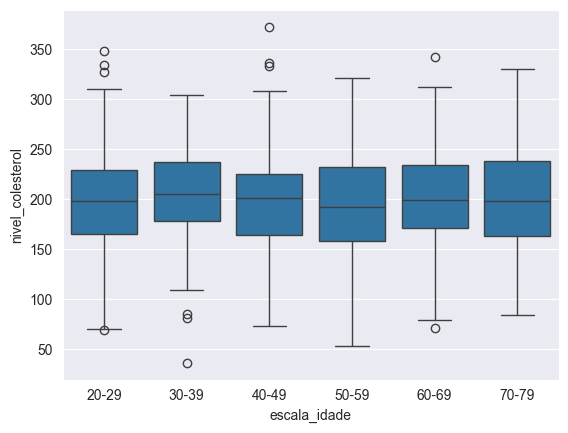

In [41]:
sns.boxplot(data=df_colesterol_bucketing, x='escala_idade', y='nivel_colesterol')

In [42]:
# Bucket Peso
bins_idade = [40, 50, 60, 70, 80, 90, 110, 120, 130, 140, 150, 160]
labens_idade = ['40-49', '50-59', '60-69', '70-79','80-89', '100-109', '110-119', '120-229', '130-139', '140-149', '150-159']
df_colesterol_bucketing['escala_peso'] = pd.cut(x=df_colesterol_bucketing['peso'], bins=bins_idade, labels=labens_idade, include_lowest=True)


<Axes: xlabel='escala_peso', ylabel='nivel_colesterol'>

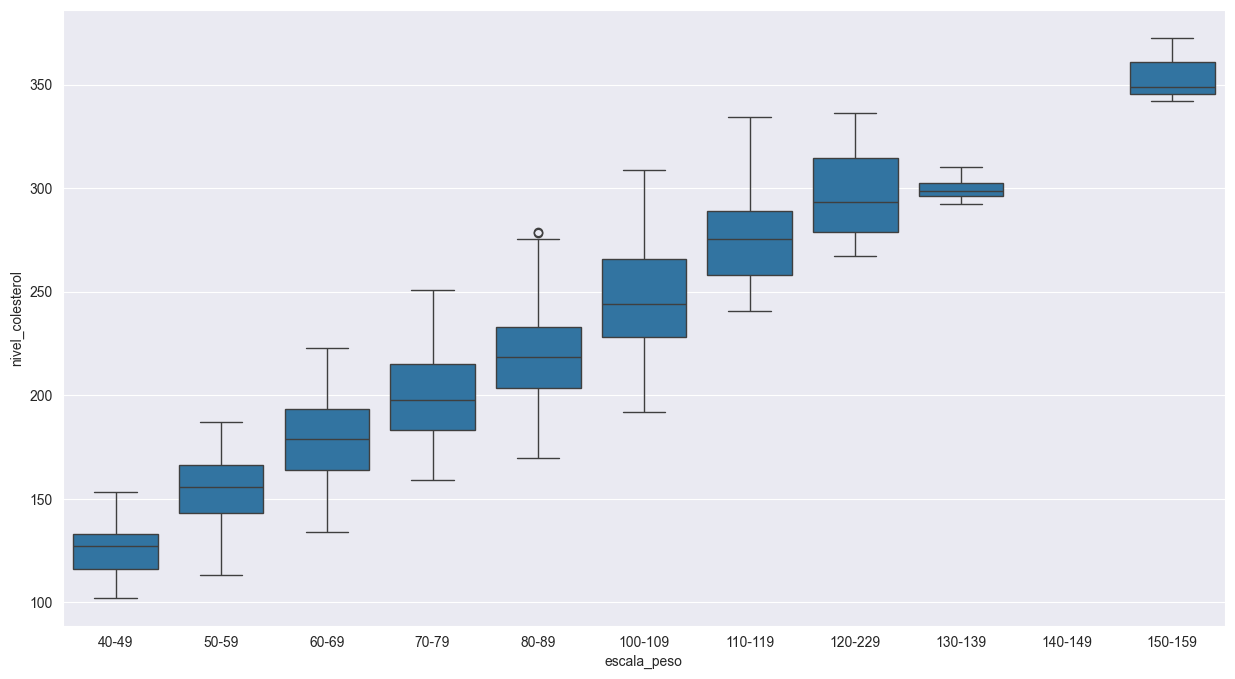

In [43]:
# Boxplot
plt.figure(figsize=(15,8))
sns.boxplot(data=df_colesterol_bucketing, x='escala_peso', y='nivel_colesterol')

In [44]:
# Criar dataset de treino e teste
df_colesterol.drop(df_colesterol[df_colesterol['peso'] < 40].index, axis=0, inplace=True)

In [45]:
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 960 non-null    object 
 2   nivel_atividade_fisica  959 non-null    object 
 3   idade                   960 non-null    float64
 4   peso                    960 non-null    float64
 5   altura                  960 non-null    float64
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(4), object(3)
memory usage: 60.2+ KB


In [46]:
X = df_colesterol.drop(columns=['nivel_colesterol'], axis=1)
y = df_colesterol['nivel_colesterol']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=51)

In [48]:
y_test.shape

(289,)

In [49]:
# Criar um pipeline para tratar os dados
# Impurar moda nas variaveis categoricas - grupo_sanguineo, fumante, nivel_atividade_fisica
# Criar um pipeline para tratar os dados
# Padronizar as variaveis numericas - idade, peso, altura
# One Hot Encoding para as variaveis categoricas nominais - grupo_sanguineo, fumante
# Ordinal Encoding para as variaveis categoricas ordinais - nivel_atividade_fisica
# Imputar a mediana para os valores nulos - idade, peso, altura

# Nomes das colunas 
colunas_categoricas = ['grupo_sanguineo', 'fumante']
colunas_numericas = ['idade', 'altura', 'peso']
colunas_ordinais = ['nivel_atividade_fisica']

In [50]:
# Transforme categoricas
transforme_categorias = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [51]:
# Transforme para variaveis ordinais
transforme_ordinais = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Baixo', 'Moderado', 'Alto']], handle_unknown='error'))
])

In [52]:
# Transforme numericas
transforme_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [53]:
# Criar um column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transforme_numericas, colunas_numericas),
        ('cat', transforme_categorias, colunas_categoricas),
        ('ord', transforme_ordinais, colunas_ordinais)
    ]
)

In [54]:
# Criando a pipeline = Pre processamento + modelo
model_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelo', LinearRegression())
])

In [55]:
# Treinando o modelo
model_regr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'altura', 'peso']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grupo_sanguineo',
                                                   'fumante']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Baixo',
                                                                                               'Moderado',
                                                                                               'Alto']]))]),
                                                  ['nivel_atividade_fisica'])])),
                ('modelo', LinearRegression())])

# Analise do modelo

In [56]:
# Gerar a predição
y_pred = model_regr.predict(X_test)


In [57]:
# Calculando o R2 score
r2_score(y_test, y_pred)

0.9594250724093464

In [58]:
# Calculando o erro médio absoluto
mean_absolute_error(y_test, y_pred)

7.313838031022505

In [59]:
# Calculando RMSE - Root Mean Absolute Error
mean_squared_error(y_test, y_pred, squared=False)

/Users/devdanalmeida/.local/share/virtualenvs/regressao_linear_multipla-ZpeQinkU/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.097649246487032

### Analise de residuos

In [60]:
# Calculando os residuos
residuos = y_test - y_pred

In [61]:
# Transformando os residuos na escala padrao
# (x - media) / desvio padrao
residuos_std = zscore(residuos)


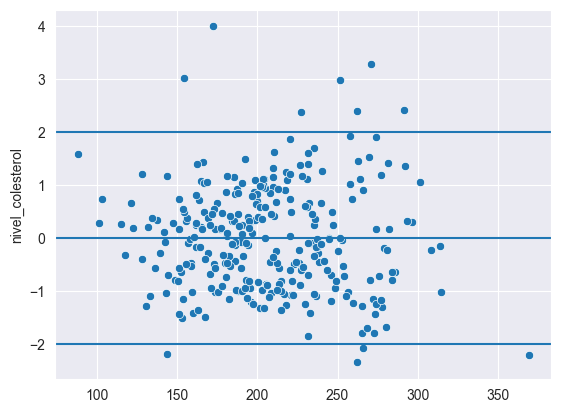

In [62]:
# Verificar linearidade dos residuos: Valores  estao entre -2 e 2
# Verificar homocedasticidade: Valores entorno da reta
sns.scatterplot(x=y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

<Axes: xlabel='nivel_colesterol', ylabel='Count'>

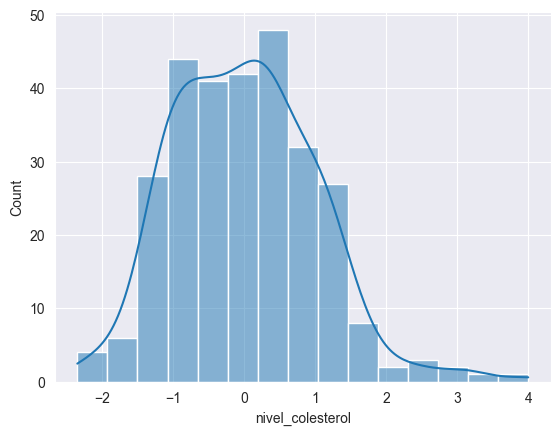

In [63]:
# Verificar normalidade dos residuos
# QQ Plot
sns.histplot(residuos_std, kde=True)

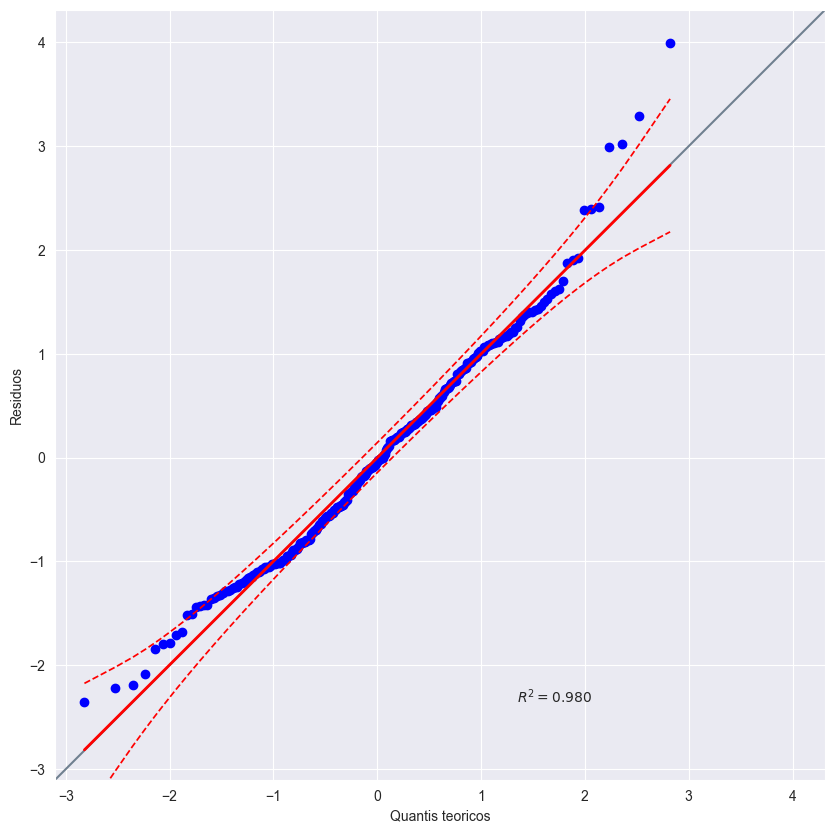

In [64]:
# Verificar normalidade dos residuos
# QQ Plot
plt.figure(figsize=(10, 10))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis teoricos')
plt.ylabel('Residuos')
plt.show()  

In [65]:
# Testes statistico para verificar normalidade dos residuos
# Shapiro-Wilk
stat_shapiro, p_value_shapiro, = shapiro(residuos)
print('Statistico Shapiro-Wilk: {}, P-Value: {}'.format(stat_shapiro, p_value_shapiro))

Statistico Shapiro-Wilk: 0.9807737729720742, P-Value: 0.0006268860444493321


In [66]:
# Teste de Kolmogorov-Smirnov
stat_kstest, p_value_kstest = kstest(residuos, 'norm')
print(f'Statistico Kolmogorov-Smirnov: {stat_kstest}, P-Value: {p_value_kstest}'.format(stat_kstest, p_value_kstest))

Statistico Kolmogorov-Smirnov: 0.42455920998485613, P-Value: 8.925833190910163e-48


In [67]:
# Teste de Linfors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Statistico Lilliefors: {stat_ll}, P-Value: {p_value_ll}'.format(stat_ll, p_value_ll))

Statistico Lilliefors: 0.04955371030192918, P-Value: 0.12533323720735734


In [68]:
# Teste de Anderson-Darling
stat_anderson, critical_and, significance_and = anderson(residuos, dist='norm')

In [69]:
critical_and

array([0.568, 0.647, 0.776, 0.906, 1.077])

In [70]:
significance_and

array([15. , 10. ,  5. ,  2.5,  1. ])

In [73]:
print('Estatistica do teste: {},e valor critico: {}'.format(stat_anderson, critical_and[2]))


Estatistica do teste: 0.9169275158490109,e valor critico: 0.776


In [74]:
# Teste de homocedasticidade de Goldfeld-Quandt
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)])
x_teste_transformado = pipe.fit_transform(X_test)

In [75]:
x_teste_transformado

array([[-1.44340738, -0.58669129,  0.22608781, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.28157488, -1.05685776, -1.20886474, ...,  1.        ,
         0.        ,  0.        ],
       [-1.10973608, -0.35160806, -0.84754575, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.00250157, -1.52702423, -1.09014564, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.28056099, -0.35160806,  0.17447081, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.72545605, -1.17439938, -1.65277092, ...,  0.        ,
         1.        ,  0.        ]])

In [79]:

# Teste de homocedasticidade
# Teste de Goldfeld-Quandt
teste_goldfeld = het_goldfeldquandt(residuos, x_teste_transformado)
stat_goldfeld = teste_goldfeld[0]
p_value_goldfeld = teste_goldfeld[1]
print('Estatistica do teste Goldfeld-Quandt: {}, P-Value: {}'.format(stat_goldfeld, p_value_goldfeld))

Estatistica do teste Goldfeld-Quandt: 0.671613576525354, P-Value: 0.9893959472385482


### Realizar a predição individuais 


In [87]:
predicao_individual = {
    'grupo_sanguineo': 'O',
    'fumante': 'Não',
    'nivel_atividade_fisica': 'Alto',
    'idade': 40,
    'peso': 70,
    'altura': 180
    
}
sample_df = pd.DataFrame(predicao_individual, index=[1])

In [82]:
sample_df

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura
1,0,0,Alto,40,80,180


In [94]:
# Realizar a predição
model_regr.predict(sample_df)

array([165.32375099])

In [92]:
df_colesterol.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79
3,A,Não,Alto,43.0,120.2,167.0,336.24
4,AB,Não,Baixo,79.0,88.5,175.0,226.23
5,B,Não,Baixo,68.0,66.8,170.0,185.31
6,A,Sim,Baixo,60.0,117.3,181.0,289.33
7,O,Sim,Moderado,35.0,86.9,174.0,216.48
8,O,Não,Baixo,62.0,81.3,166.0,235.30
10,A,Sim,Baixo,57.0,123.6,183.0,283.87


In [93]:
# Visualizar os dados
df_colesterol.info(10)

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 960 non-null    object 
 2   nivel_atividade_fisica  959 non-null    object 
 3   idade                   960 non-null    float64
 4   peso                    960 non-null    float64
 5   altura                  960 non-null    float64
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(4), object(3)
memory usage: 60.2+ KB


In [91]:
# Salvar modelo
joblib.dump(model_regr, '.escola /modelo_colesterol.pkl')

['./modelo_colesterol.pkl']